In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV, LassoCV
import warnings
warnings.filterwarnings('ignore')



In [174]:
file_path = '../RiceDatathon/OilData.csv'
data = pd.read_csv(file_path)


In [175]:
data_cleaned = data.dropna(subset=['OilPeakRate'])
data_cleaned.drop(columns="Unnamed: 0", inplace=True)

# Splitting the dataset
data_with_oilpeak = data_cleaned.copy()
data_without_oilpeak = data_cleaned[data_cleaned['OilPeakRate'].isnull()].copy()

# Handling missing values efficiently
for column in data.columns:
    if data[column].isnull().sum() > 0:
        if data[column].dtype == 'object':
            mode_value = data[column].mode()[0]
        else:
            median_value = data[column].median()

        data_with_oilpeak[column].fillna(mode_value if data[column].dtype == 'object' else median_value, inplace=True)
        data_without_oilpeak[column].fillna(mode_value if data[column].dtype == 'object' else median_value, inplace=True)

# Dropping columns with high percentage of missing values
threshold = 50
columns_to_drop = data_with_oilpeak.columns[data_with_oilpeak.isnull().mean() > threshold / 100]
data_with_oilpeak.drop(columns=columns_to_drop, inplace=True)

# Removing outliers
numeric_cols = data_with_oilpeak.select_dtypes(include=['number']).columns
Q1 = data_with_oilpeak[numeric_cols].quantile(0.25)
Q3 = data_with_oilpeak[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (data_with_oilpeak[numeric_cols] < (Q1 - 1.5 * IQR)) | (data_with_oilpeak[numeric_cols] > (Q3 + 1.5 * IQR))
data_with_oilpeak_reduced = data_with_oilpeak[~outlier_mask.any(axis=1)]

# Separating the target variable
target_data = data_with_oilpeak_reduced[['OilPeakRate']].copy()
target_variable = "OilPeakRate"
data_with_oilpeak_reduced.drop(columns=['OilPeakRate'], inplace=True)

# Output
print("Shape of target data:", target_data.shape)
print("Shape of features data:", data_with_oilpeak_reduced.shape)

Shape of target data: (12490, 1)
Shape of features data: (12490, 29)


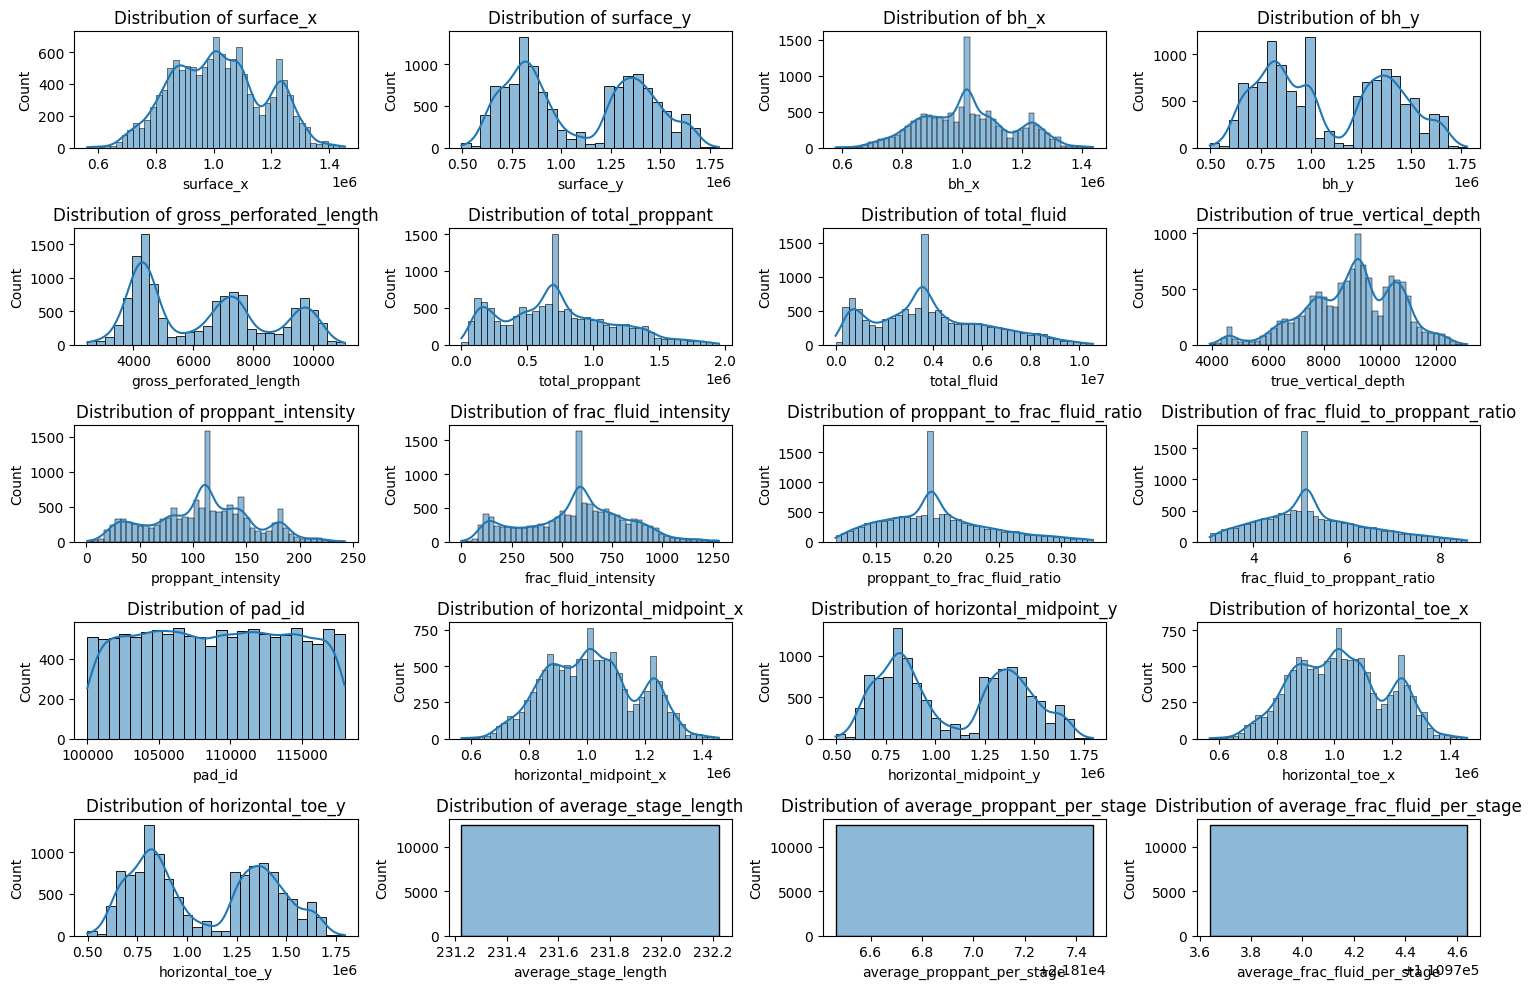

In [176]:
numerical_columns = ['surface_x','surface_y','bh_x','bh_y','gross_perforated_length','total_proppant', 'total_fluid',
                     'true_vertical_depth','proppant_intensity','frac_fluid_intensity','proppant_to_frac_fluid_ratio',
                     'frac_fluid_to_proppant_ratio','pad_id','horizontal_midpoint_x','horizontal_midpoint_y',
                     'horizontal_toe_x','horizontal_toe_y','average_stage_length','average_proppant_per_stage','average_frac_fluid_per_stage'] 

plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 4, i)
    sns.histplot(data_with_oilpeak_reduced[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

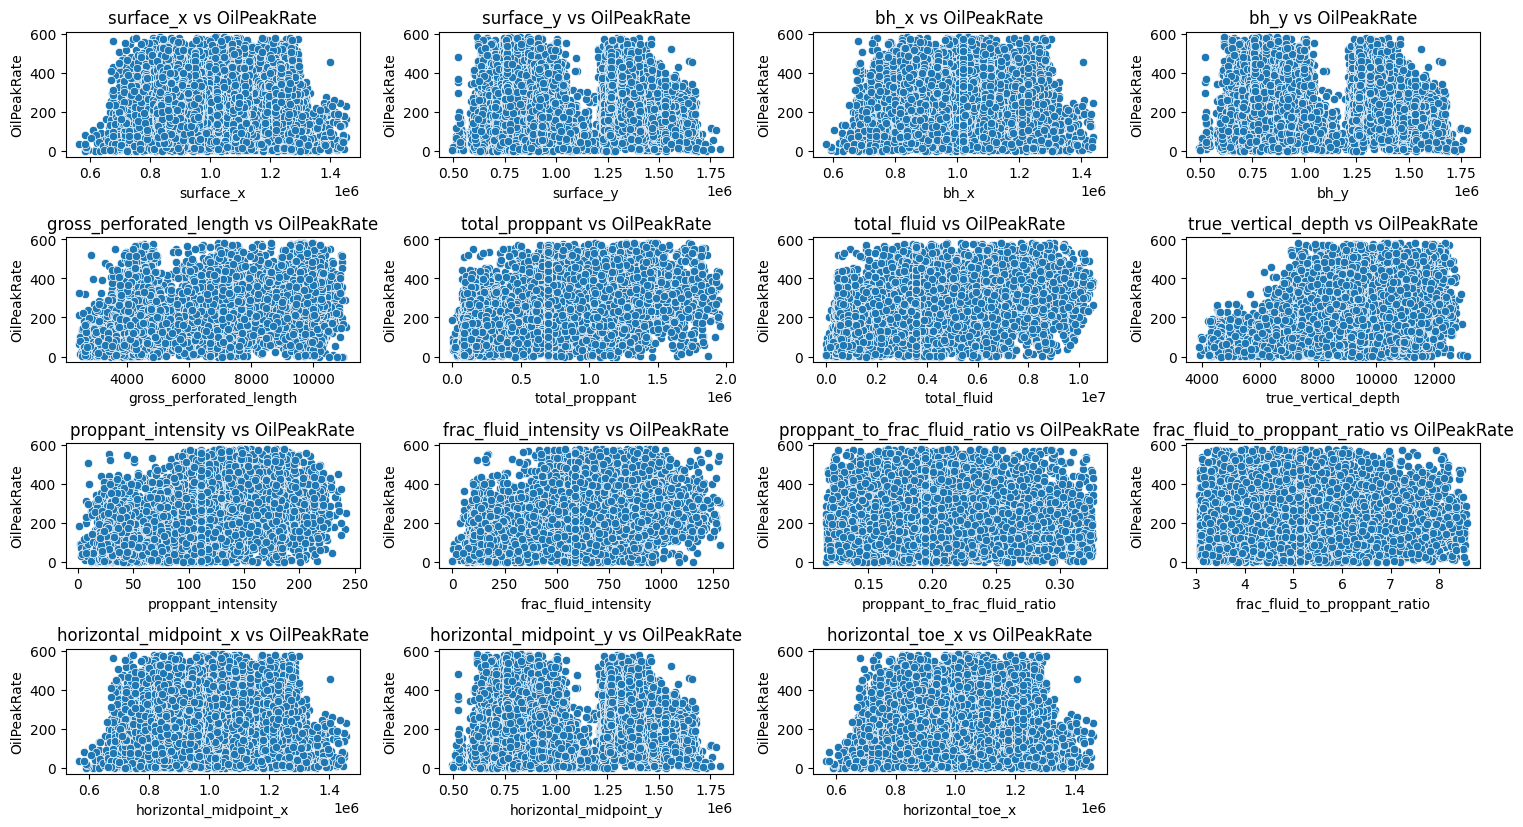

In [177]:
data_with_oilpeak_reduced = data_with_oilpeak_reduced.drop(columns=['average_stage_length','average_proppant_per_stage','average_frac_fluid_per_stage','pad_id'])
numerical_columns = ['surface_x','surface_y','bh_x','bh_y','gross_perforated_length','total_proppant', 'total_fluid',
                     'true_vertical_depth','proppant_intensity','frac_fluid_intensity','proppant_to_frac_fluid_ratio',
                     'frac_fluid_to_proppant_ratio','horizontal_midpoint_x','horizontal_midpoint_y','horizontal_toe_x','horizontal_toe_y'] 
plt.figure(figsize=(15, 10))

# Assuming numerical_columns contains the names of your numerical feature columns
for i, column in enumerate(numerical_columns[:-1], 1):
    plt.subplot(5, 4, i)
    sns.scatterplot(x=data_with_oilpeak_reduced[column], y=target_data[target_variable])
    plt.title(f'{column} vs {target_variable}')

plt.tight_layout()
plt.show()

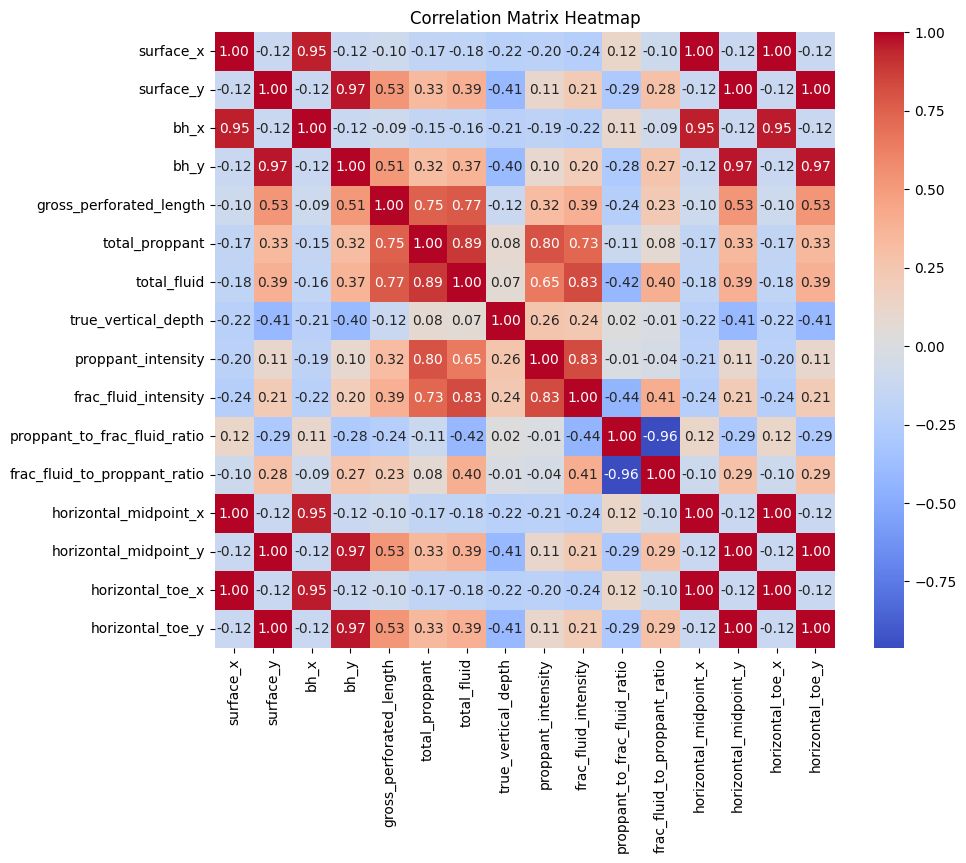

In [178]:
corr_matrix = data_with_oilpeak_reduced[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [179]:
surface_coordinates = data_with_oilpeak_reduced[['surface_x', 'surface_y']]
kmeans_surface = KMeans(n_clusters=4)
surface_clusters = kmeans_surface.fit_predict(surface_coordinates)
data_with_oilpeak_reduced['surface_cluster'] = surface_clusters

bh_coordinates = data_with_oilpeak_reduced[['bh_x', 'bh_y']]
kmeans_bh = KMeans(n_clusters=5)
bh_clusters = kmeans_bh.fit_predict(bh_coordinates)
data_with_oilpeak_reduced['bh_cluster'] = bh_clusters

mid_coordinates = data_with_oilpeak_reduced[['horizontal_midpoint_x', 'horizontal_midpoint_y']]
kmeans_mid = KMeans(n_clusters=5)
mid_clusters = kmeans_mid.fit_predict(mid_coordinates)
data_with_oilpeak_reduced['mid_clusters'] = mid_clusters

toe_coordinates = data_with_oilpeak_reduced[['horizontal_toe_x', 'horizontal_toe_y']]
kmeans_toe = KMeans(n_clusters=5)
toe_clusters = kmeans_toe.fit_predict(toe_coordinates)
data_with_oilpeak_reduced['toe_clusters'] = toe_clusters

data_with_oilpeak_reduced.head()


,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,...,frac_type,frac_seasoning,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,surface_cluster,bh_cluster,mid_clusters,toe_clusters
0,1383493.751,717329.2368,1382854.564,712767.3700,1121,3963.582677,27.0,76000.00000,3.564951e+06,8712.598425,...,Primary Frac,38.0,1383030.678,714796.3610,1382668.912,712798.4321,0,3,0,0
1,1380344.035,711916.2732,1379738.429,707860.5643,1022,3179.133858,27.0,113000.00000,5.610964e+05,8627.952756,...,Primary Frac,38.0,1379965.126,709541.7145,1379630.025,707907.6708,0,3,0,0
4,1378962.585,702623.9787,1379643.546,707204.9131,1022,3811.023622,27.0,112789.71430,6.229802e+05,8664.370079,...,Primary Frac,38.0,1379546.414,705150.7519,1379987.487,707123.7258,0,3,0,0
5,1381250.408,702293.2344,1381927.722,706874.3795,1022,3536.417323,27.0,93000.00000,5.638857e+05,8668.307087,...,Primary Frac,38.0,1382166.864,704872.4045,1382717.737,706720.3298,0,3,0,0
7,1388889.586,706536.1570,1388895.735,706578.6413,1349,4673.228346,27.0,91142.85714,6.095996e+05,8704.724409,...,Primary Frac,38.0,1389357.383,709030.8139,1389741.421,711055.9529,0,3,0,0


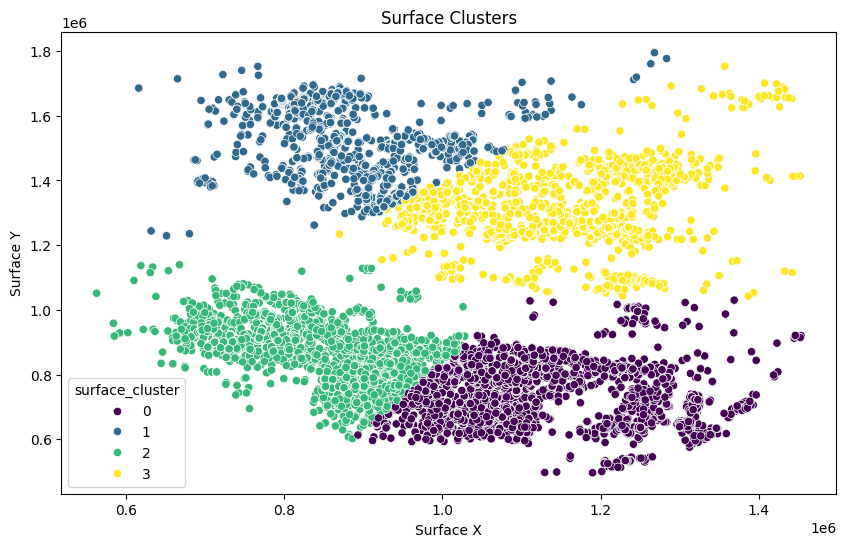

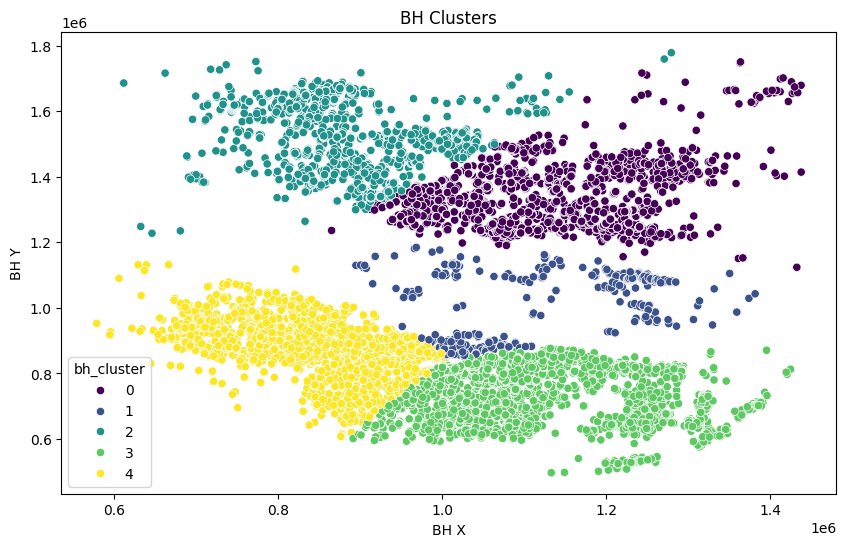

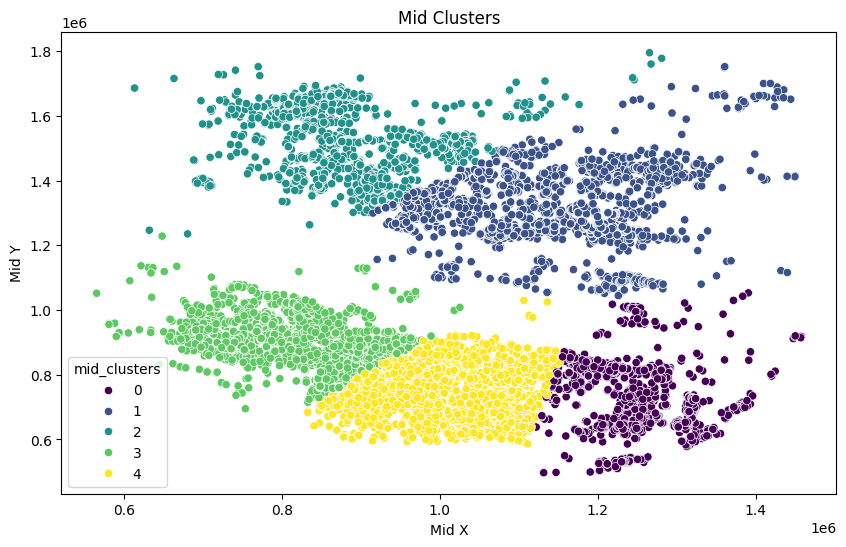

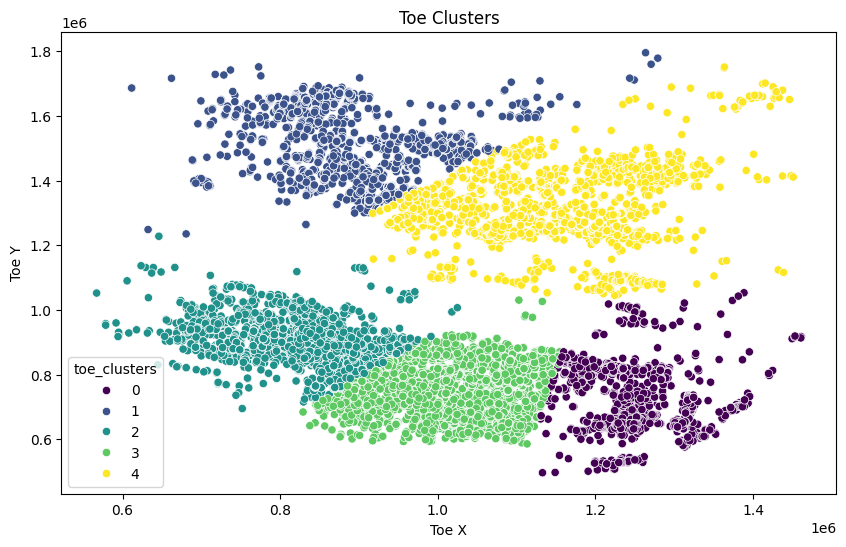

In [180]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='surface_x', y='surface_y', hue='surface_cluster', data=data_with_oilpeak_reduced, palette='viridis')
plt.title('Surface Clusters')
plt.xlabel('Surface X')
plt.ylabel('Surface Y')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='bh_x', y='bh_y', hue='bh_cluster', data=data_with_oilpeak_reduced, palette='viridis')
plt.title('BH Clusters')
plt.xlabel('BH X')
plt.ylabel('BH Y')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='horizontal_midpoint_x', y='horizontal_midpoint_y', hue='mid_clusters', data=data_with_oilpeak_reduced, palette='viridis')
plt.title('Mid Clusters')
plt.xlabel('Mid X')
plt.ylabel('Mid Y')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='horizontal_toe_x', y='horizontal_toe_y', hue='toe_clusters', data=data_with_oilpeak_reduced, palette='viridis')
plt.title('Toe Clusters')
plt.xlabel('Toe X')
plt.ylabel('Toe Y')
plt.show()

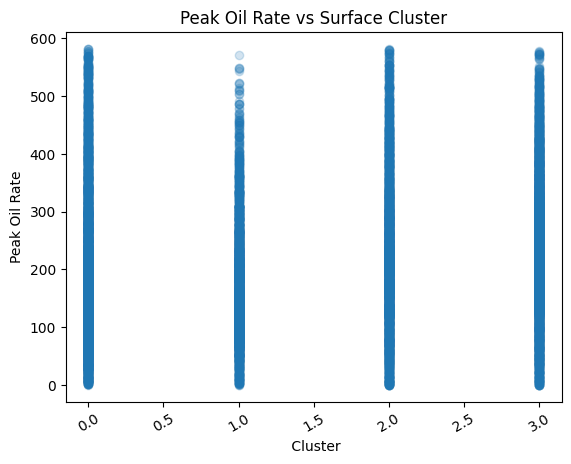

In [181]:
x = data_with_oilpeak_reduced['surface_cluster']
y = target_data[target_variable]

plt.plot(x, y, 'o', alpha=0.2) 
plt.xlabel(' Cluster')
plt.ylabel('Peak Oil Rate')
plt.title('Peak Oil Rate vs Surface Cluster')
plt.xticks(rotation=30)
plt.show()

In [182]:
data_with_cluster = data_with_oilpeak_reduced.drop(columns=["bh_x","bh_y","bh_cluster","mid_clusters",
                                                       "toe_clusters","horizontal_midpoint_x","horizontal_midpoint_y",
                                                       "horizontal_toe_x","horizontal_toe_y","surface_cluster"])
data_with_cluster.info()
print(data_with_cluster.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 12490 entries, 0 to 29436
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   surface_x                     12490 non-null  float64
 1   surface_y                     12490 non-null  float64
 2   standardized_operator_name    12490 non-null  int64  
 3   gross_perforated_length       12490 non-null  float64
 4   number_of_stages              12490 non-null  float64
 5   total_proppant                12490 non-null  float64
 6   total_fluid                   12490 non-null  float64
 7   true_vertical_depth           12490 non-null  float64
 8   ffs_frac_type                 12490 non-null  object 
 9   proppant_intensity            12490 non-null  float64
 10  frac_fluid_intensity          12490 non-null  float64
 11  proppant_to_frac_fluid_ratio  12490 non-null  float64
 12  frac_fluid_to_proppant_ratio  12490 non-null  float64
 13  bin_la

In [183]:
categorical_cols = ['ffs_frac_type', 'relative_well_position', 'batch_frac_classification', 'well_family_relationship', 'frac_type']

for col in categorical_cols:
    le = LabelEncoder()
    data_with_cluster[col] = le.fit_transform(data_with_cluster[col])

Y = target_data['OilPeakRate']
X = data_with_cluster.drop(columns=['number_of_stages'])

infinite_cols = X.columns.to_series()[np.isinf(X).any()]

X.replace([np.inf, -np.inf], np.nan, inplace=True)

X = X.fillna(X.median())

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            OilPeakRate   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     430.6
Date:                Sun, 21 Jan 2024   Prob (F-statistic):               0.00
Time:                        00:39:57   Log-Likelihood:                -75187.
No. Observations:               12490   AIC:                         1.504e+05
Df Residuals:                   12472   BIC:                         1.505e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [184]:
def forward_selection(X, Y, significance_level=0.01):
    initial_features = X.columns.tolist()
    best_features = []
    
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(Y, sm.add_constant(X[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < significance_level:
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

selected_features = forward_selection(X, Y)
print("Selected features:", selected_features)

X_selected = sm.add_constant(X[selected_features])
model = sm.OLS(Y, X_selected).fit()
print(model.summary())

Selected features: ['total_proppant', 'const', 'true_vertical_depth', 'surface_x', 'gross_perforated_length', 'proppant_intensity', 'surface_y', 'batch_frac_classification', 'frac_seasoning', 'total_fluid', 'frac_fluid_to_proppant_ratio', 'relative_well_position', 'standardized_operator_name', 'well_family_relationship']
                            OLS Regression Results                            
Dep. Variable:            OilPeakRate   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     562.1
Date:                Sun, 21 Jan 2024   Prob (F-statistic):               0.00
Time:                        00:39:58   Log-Likelihood:                -75191.
No. Observations:               12490   AIC:                         1.504e+05
Df Residuals:                   12476   BIC:                         1.505e+05
Df Model:                          13        

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, Y, test_size=0.07, random_state=0)

random_forest_model = RandomForestRegressor(random_state=0)

# param_grid = {
#     'n_estimators': [100],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_

best_params = {
    'n_estimators': 100,           # Number of trees in the forest
    'max_depth': None,             # No maximum depth for the trees
    'min_samples_split': 5,        # Minimum number of samples required to split an internal node
    'min_samples_leaf': 2,         # Minimum number of samples required to be at a leaf node
    'max_features': 'sqrt',        # Number of features to consider for each split: sqrt(total_features)
    'bootstrap': True              # Use bootstrap sampling for building trees
}

print(best_params)


best_rf_model = RandomForestRegressor(**best_params, random_state=0)

# Number of folds for K-Fold Cross-Validation
num_folds = 5

# Perform cross-validation
cv_scores = cross_val_score(best_rf_model, X_selected, Y, cv=num_folds, scoring='neg_root_mean_squared_error')

# Convert the scores to positive RMSE (since they are negative)
cv_rmse_scores = -cv_scores

# Calculate the average and standard deviation of the RMSE scores
average_cv_rmse = np.mean(cv_rmse_scores)
std_dev_cv_rmse = np.std(cv_rmse_scores)

print("Average CV RMSE:", average_cv_rmse)
print("Standard Deviation of CV RMSE:", std_dev_cv_rmse)

# Fit the model on the entire training data
best_rf_model.fit(X_train, y_train)

# Predict and evaluate as before
y_train_pred = best_rf_model.predict(X_train)
y_test_pred = best_rf_model.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)

# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
print(comparison_df.head())

{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
Average CV RMSE: 99.90852101717908
Standard Deviation of CV RMSE: 7.380238659773686
Training RMSE: 47.245535277899194
Testing RMSE: 78.79936534297781
           Actual   Predicted
14620  202.557968  250.230735
11968  479.709258  399.852614
16070  233.678608  288.868497
1003    76.353328   59.412037
2265   409.607206  371.948982


In [186]:
print(best_params)
# X_test.to_csv('lasttestx.csv', index=False)


{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
